In [2]:
import pandas as pd
import tweepy 
from tweepy import OAuthHandler

In [3]:
def TwitterClient(): 
    # keys and tokens from the Twitter Dev Console 
    api_key = "xQGrEytN0KSsEERUlbA3Mwjdv"
    api_secret = "N7ModRAyQqtFkB4jvI1o0nCooyfSGfZZUAaIfHTQp3iiUGutKi"
    access = "3118781631-GnQENiXAMouhIuhas2ol14A4b9zyChTR927WZmW"
    access_secret = "frEmYjSFnETQka3sOtTb2x6oCOAkFHDmSivcgrqULytRL"

    # attempt authentication 
    try: 
        # create OAuthHandler object 
        auth = OAuthHandler(api_key, api_secret) 
        # set access token and secret 
        auth.set_access_token(access, access_secret) 
        # create tweepy API object to fetch tweets 
        api = tweepy.API(auth) 
    except: 
        print("Error: Authentication Failed") 

    return api #now we can make request to twitter using this api

In [4]:
api = TwitterClient()

#get tweets from a user and add the tweets to a dataframe
def get_tweets(user_name):
    tweets = []
    for tweet in tweepy.Cursor(api.user_timeline, id=user_name).items():
        tweets.append(tweet)
    df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
    return df

In [ ]:
jeff_tweets = get_tweets('JeffBezos')
jeff_tweets.columns = ['Jeff Bezos']

elon_tweets = get_tweets('elonmusk')
elon_tweets.columns = ['Elon Musk']

snoop_tweets = get_tweets('SnoopDogg')
snoop_tweets.columns = ["Snoop Dogg"]

taylor_tweets = get_tweets('taylorswift13')
taylor_tweets.columns = ["Taylor Swift"]

slash_tweets = get_tweets('Slash')
slash_tweets.columns = ["Slash"]

wiz_tweets = get_tweets('wizkhalifa')
wiz_tweets.columns = ["Wiz Khalifa"]

nat_geo_tweets = get_tweets('natGeo')
nat_geo_tweets.columns = ["National Geographic"]

bbc_earth_tweets = get_tweets('BBCEarth')
bbc_earth_tweets.columns = ["BBC Earth"]

biden_tweets = get_tweets('JoeBiden')
biden_tweets.columns = ["Joe Biden"]

nasa_tweets = get_tweets('NASA')
nasa_tweets.columns = ["NASA"]

nba_tweets = get_tweets('NBA')
nba_tweets.columns = ["NBA"]

ronaldo_tweets = get_tweets('Cristiano')
ronaldo_tweets.columns = ["Cristiano Ronaldo"]

neymar_tweets = get_tweets('neymarjr')
neymar_tweets.columns = ["Neymar Jr"]

lexFridman_tweets = get_tweets('lexfridman')
lexFridman_tweets.columns = ["Lex Fridman"]

tesla_tweets = get_tweets('Tesla')
tesla_tweets.columns = ["Tesla"]

dogecoin_tweets = get_tweets('dogecoin')
dogecoin_tweets.columns = ["Dogecoin"]

jackDorsey_tweets = get_tweets('jack')
jackDorsey_tweets.columns = ["Jack Dorsey"]

In [ ]:
df = pd.DataFrame()
df["Jeff Bezos"] = jeff_tweets["Jeff Bezos"]
df["Elon Musk"] = elon_tweets["Elon Musk"]
df["Snoop Dogg"] = snoop_tweets["Snoop Dogg"]
df["Taylor Swift"] = taylor_tweets["Taylor Swift"]
df["Slash"] = slash_tweets["Slash"]
df["Wiz Khalifa"] = wiz_tweets["Wiz Khalifa"]
df["National Geographic"] = nat_geo_tweets["National Geographic"]
df["BBC Earth"] = bbc_earth_tweets["BBC Earth"]
df["Joe Biden"] = biden_tweets["Joe Biden"]
df["NASA"] = nasa_tweets["NASA"]
df["NBA"] = nba_tweets["NBA"]
df["Cristiano Ronaldo"] = ronaldo_tweets["Cristiano Ronaldo"]
df["Neymar Jr"] = neymar_tweets["Neymar Jr"]
df["Lex Fridman"] = lexFridman_tweets["Lex Fridman"]
df["Tesla"] = tesla_tweets["Tesla"]
df["Dogecoin"] = dogecoin_tweets["Dogecoin"]
df["Jack Dorsey"] = jackDorsey_tweets["Jack Dorsey"]

In [171]:
# save the dataframe to a csv file
df.to_csv('tweets.csv')

In [173]:
df = pd.read_csv('tweets.csv', index_col=0)
df

,Jeff Bezos,Elon Musk,Snoop Dogg,Taylor Swift,Slash,Wiz Khalifa,National Geographic,BBC Earth,Joe Biden,NASA,NBA,Cristiano Ronaldo,Neymar Jr,Lex Fridman,Tesla,Dogecoin,Jack Dorsey
0,"['bill', 'without', 'doubt', 'one', 'smartest'...","['reuters', 'copycats']","['ffckl', 'vcxi']","['ps', 'wrote', 'tweet', 'case', 'wondering']","['reposted', 'creepydollyy', 'art', 'patrick',...","['mcqueenvf', 'lzdj', 'nmqei']","['scientists', 'ever', 'know', 'whether', 'uni...","['photographing', 'night', 'sky', 'requires', ...","['today', 'learned', 'economy', 'created', 'jo...","['crew', 'completes', 'nearly', 'six', 'month'...","['check', 'playoffs', 'bracket', 'depth', 'cov...","['download', 'livescore', 'app', 'never', 'mis...","['thank', 'great', 'launch', 'event', 'yesterd...","['found', 'street', 'world', 'possibilities', ...","['received', 'almost', 'million', 'job', 'appl...","['much', 'elon', 'doge', 'wow', 'drama', 'even...","['filosottile', 'way']"
1,"['zebulgar', 'read', 'seveneves', 'times', 'am...","['teslarati', 'klenderjoey', 'trend', 'well', ...","['ay', 'elonmusk', 'let', 'take', 'apes', 'moo...","['damonalbarn', 'big', 'fan', 'saw', 'write', ...","['iiii', 'hbkayotrpz']","['mcqueenvf', 'mk', 'pi']","['nearly', 'million', 'children', 'worldwide',...","['flamingos', 'pink', 'greater', 'flamingo', '...","['talk', 'deficit', 'republican', 'friends', '...","['nasauniverse', 'blackholeweek', 'get', 'exci...","['wjdnfe', 'z', 'fvsxefhrkb']","['forever', 'love', 'x', 'w', 'ryrm']","['thrilled', 'new', 'partnership', 'ego', 'mob...","['truth', 'passes', 'three', 'stages', 'first'...","['created', 'nearly', 'k', 'direct', 'new', 'j...","['wow', 'much', 'icecube', 'thebig', 'westcoas...","['bhorowitz', 'true', 'needs', 'cover']"
2,"['damn', 'cool', 'congrats', 'mimi', 'whole', ...","['strongly', 'believe', 'managers', 'technical...","['another', 'djsnoopadelic', 'mixxxxx', 'fw', ...","['say', 'say', 'okay', 'saying', 'feelin', 'al...","['official', 'music', 'video', 'april', 'fool'...","['ash', 'trays', 'flickin', 'em', 'floor']","['lush', 'farmland', 'snow', 'laced', 'mountai...","['finally', 'scratch', 'itch', 'sevenworldsone...","['plan', 'reduce', 'deficit', 'would', 'help',...","['reach', 'end', 'teacherappreciationweek', 'w...","['aq', 'pokknz', 'askwalefk']","['thanks', 'support', 'old', 'trafford', 'toni...","['que', 'deus', 'nos', 'aben', 'oe', 'e', 'nos...","['profdavidbuss', 'really', 'great', 'conversa...","['end', 'usable', 'life', 'recycle', 'battery'...","['dogecoinfdn', 'nice', 'funny', 'explainer', ...",['brockm']
3,"['good', 'use', 'twitter', 'r', 'fitcjyo']","['skorusark', 'must', 'something', 'right']","['nathanheadphoto', 'snoop', 'rocking', 'bored...","['problems', 'today', 'champagne', 'wanted', '...","['big', 'thanks', 'slashcolombia', 'years', 's...","['bitch', 'three', 'houses', 'ago', 'got', 'he...","['new', 'laws', 'accelerate', 'renewable', 'en...","['waiting', 'food', 'delivery', 'arrive', 'ale...","['potus', 'today', 'met', 'grassroots', 'worke...","['nasakennedy', 'crew', 'mission', 'officially...","['mffl', 'lpkmeasok', 'hzzqynrurn']","['hlg', 'rbi', 'sm']","['gabriel', 'medina', 'hahahahahaahahahahaha',...","['conversation', 'profdavidbuss', 'evolutionar...","['battery', 'longevity', 'critical', 'every', ...","['dogememegirl', 'despite', 'dogecoin', 'heavi...","['keemstar', 'timcast', 'elonmusk', 'pretty', ..."
4,"['see', 'musk', 'extremely', 'good', 'navigati...","['kevinmitnick', 'haha']","['gooooo', 'week', 'nite', 'americansongcontes...","['thank', 'team', 'made', 'well', 'min', 'ulti...","['happy', 'may', 'th', 'reposted', 'ham', 'n',...","['shit', 'house', 'couch', 'plan', 'tossing', ...","['years', 'iberian', 'lynx', 'gone', 'world', ...","['friend', 'share', 'food', 'rhesus', 'macaque...","['still', 'work', 'track', 'cut', 'federal', '...","['see', 'captures', 'crew', 'return', 'nasahqp...","['nbaplayoffs', 'presented', 'google', 'pixel'...",['vrnvcoegow'],"['scooby', 'e', 'pa', 'neymar', 'jr'

In [84]:
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

# convert to lower case
def lower_case(text):
    return text.lower()

# remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(["https", "co", "http", "'", "rt", "nan"])
    word_tokens = text.split()
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

columns = df.columns.tolist()

# call all 3 functions and change the dataframe in a for loop
for i in range(len(df)):
    for name in columns:
        df[name][i] = remove_punctuation(df[name][i])
        df[name][i] = lower_case(df[name][i])
        df[name][i] = remove_stop_words(df[name][i])


In [85]:
df_strings = {}
for name in columns:
    df_strings[name] = " ".join([str(word) for item in df[name] for word in item])

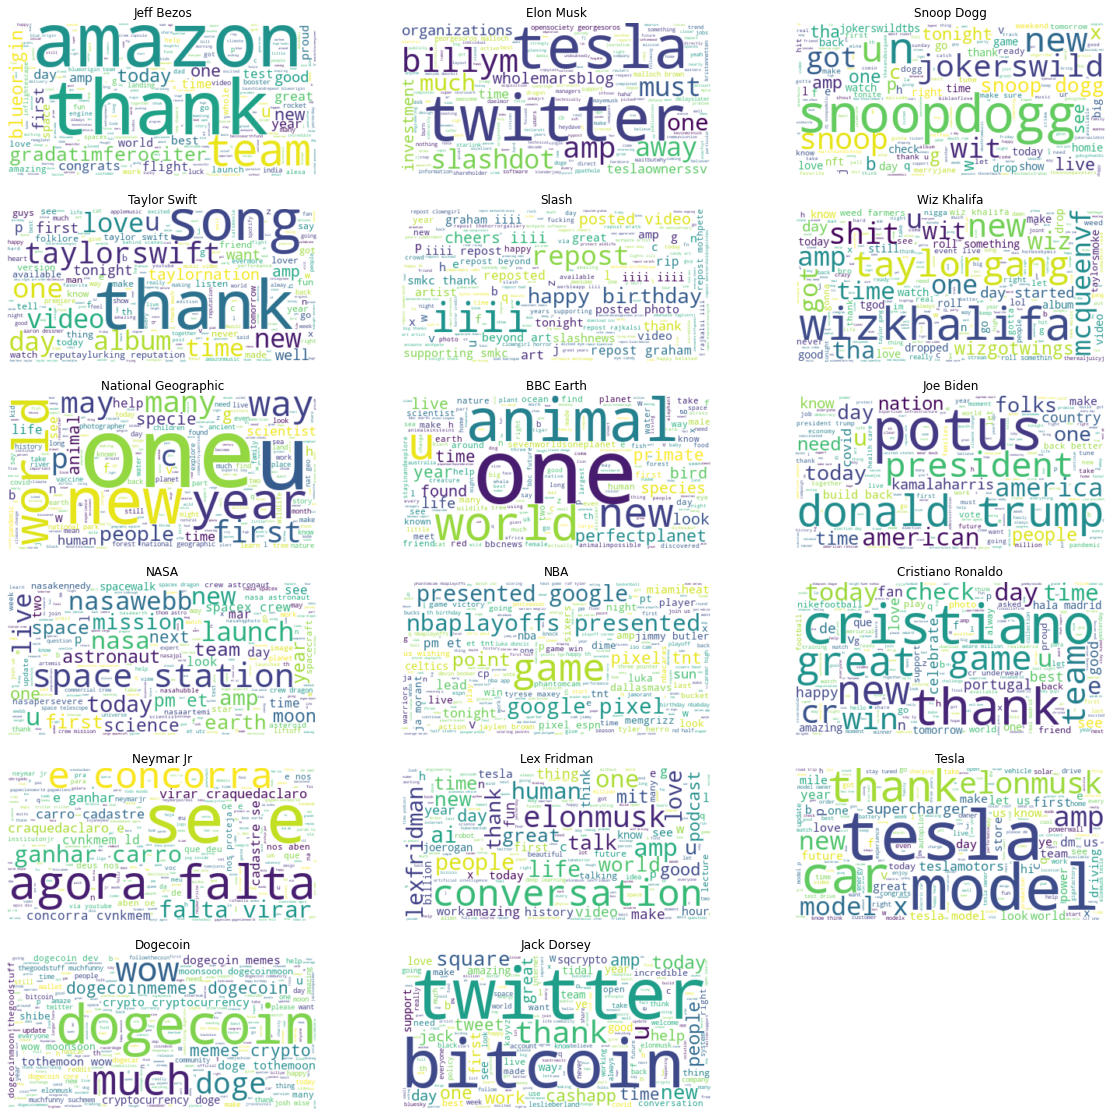

In [112]:
# create a wordcloud for each name and plot all of them in a grid
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize=(20, 20))
for i, name in enumerate(columns):
    # create a word cloud for each name
    plt.subplot(6, 3, i+1)
    wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(df_strings[name])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(name)
plt.show()

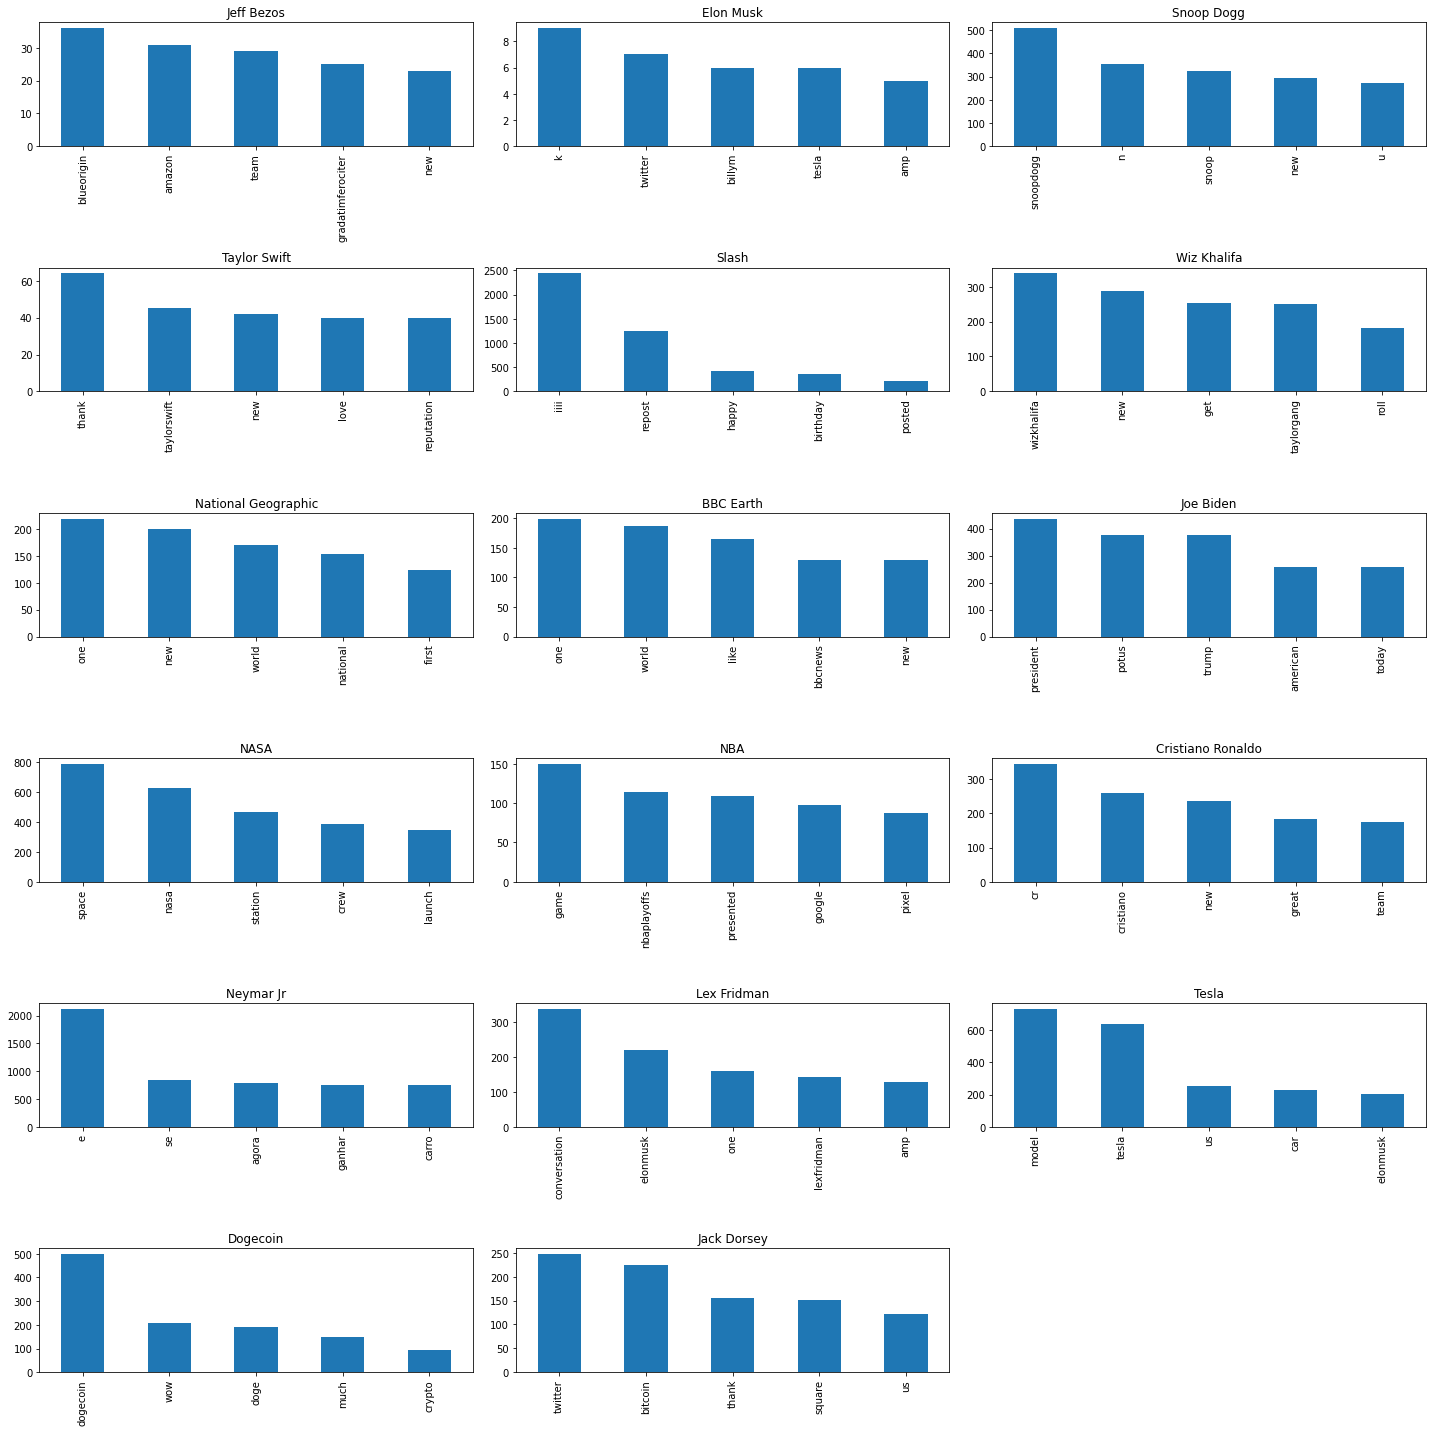

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for i, name in enumerate(columns):
    # create a word cloud for each name
    plt.subplot(6, 3, i+1)
    word_counts = pd.Series(df_strings[name].split()).value_counts()
    word_counts = word_counts[:5]
    word_counts.plot.bar()
    plt.title(name)
plt.tight_layout()
plt.show()


In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(["https", "co", "http", "'", "rt", "nan", "k", "n", "u", "iiii", "new", "e", "se", "one", "amp"])

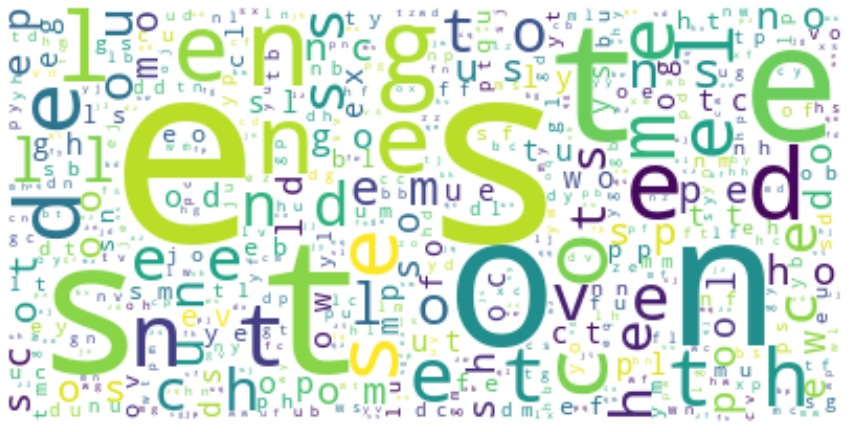

In [142]:
# join all the strings in columns and create a wordcloud
df_strings_joined = " ".join([str(word) for item in df_strings.values() for word in item])
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(df_strings_joined)
plt.figure(figsize=(15, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

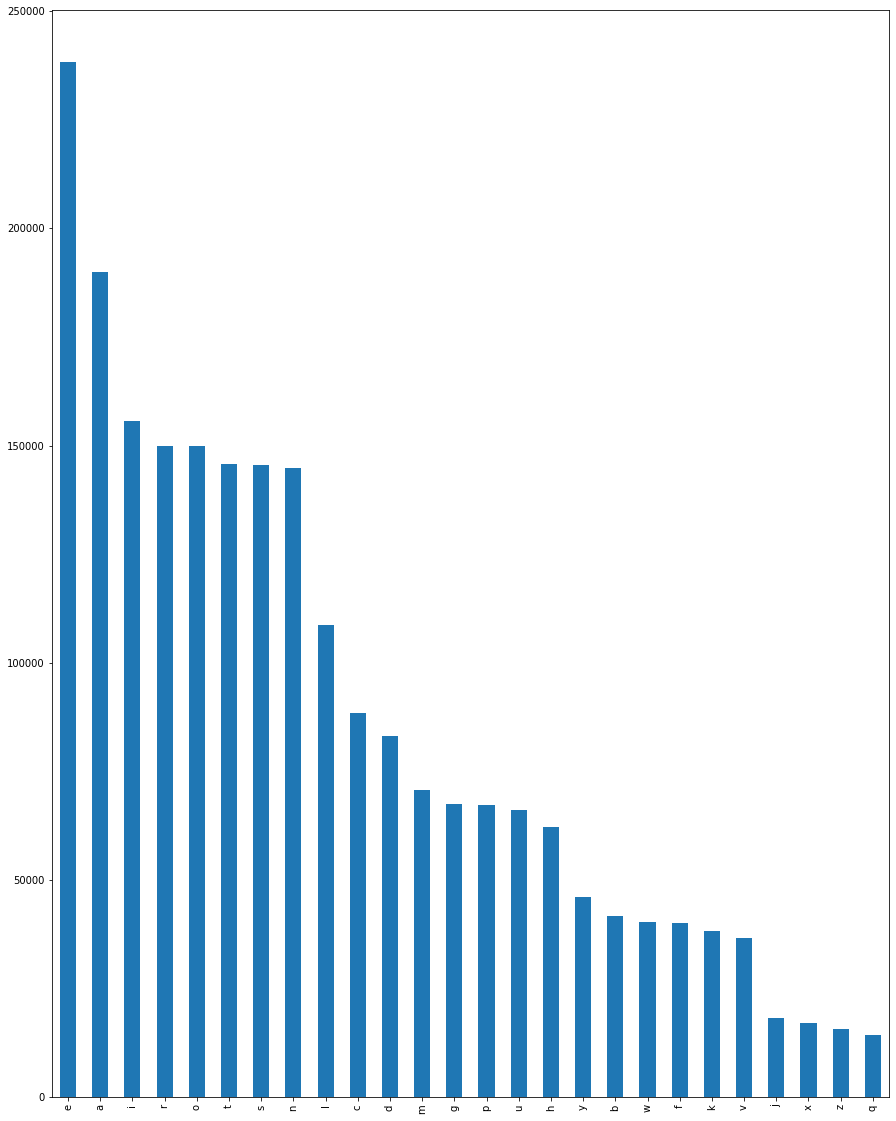

In [160]:
plt.figure(figsize=(15, 20))
word_counts = pd.Series(df_strings_joined.split()).value_counts()
word_counts = word_counts[:26]
word_counts.plot.bar()
plt.show()


In [163]:
stop_words.update(word_counts.index[:26])

In [164]:
from gensim import corpora, models, similarities
from collections import defaultdict

# documents = list of each df_string
documents = []
for name in columns:
    documents.append(df_strings[name])

texts = [[word.lower() for word in document.split() if word.lower() not in stop_words] for document in documents]

frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)


In [174]:
doc = "messi"

vec_bow = dictionary.doc2bow(doc.lower().split())

# convert the query to LSI space
vec_lsi = lsi[vec_bow]
index = similarities.MatrixSimilarity(lsi[corpus])

# perform a similarity query against the corpus
sims = index[vec_lsi]
sims = sorted(enumerate(sims), key=lambda item: -item[1])

#print sims but the names of the indexes and the points
for i in range(len(sims)):
    print(columns[sims[i][0]], sims[i][1])



Neymar Jr 0.9999998
Cristiano Ronaldo 0.19985634
Wiz Khalifa 0.07287597
NBA 0.06996624
Snoop Dogg 0.06740209
Taylor Swift 0.06462881
Jack Dorsey 0.059505433
Slash 0.053823754
Dogecoin 0.052629955
Lex Fridman 0.052540615
Jeff Bezos 0.0486383
Tesla 0.046454288
BBC Earth 0.042304873
National Geographic 0.041380003
Joe Biden 0.039352015
Elon Musk 0.037822925
NASA 0.013133749


In [172]:
df.head(
)

,Jeff Bezos,Elon Musk,Snoop Dogg,Taylor Swift,Slash,Wiz Khalifa,National Geographic,BBC Earth,Joe Biden,NASA,NBA,Cristiano Ronaldo,Neymar Jr,Lex Fridman,Tesla,Dogecoin,Jack Dorsey
0,"['bill', 'without', 'doubt', 'one', 'smartest'...","['reuters', 'copycats']","['ffckl', 'vcxi']","['ps', 'wrote', 'tweet', 'case', 'wondering']","['reposted', 'creepydollyy', 'art', 'patrick',...","['mcqueenvf', 'lzdj', 'nmqei']","['scientists', 'ever', 'know', 'whether', 'uni...","['photographing', 'night', 'sky', 'requires', ...","['today', 'learned', 'economy', 'created', 'jo...","['crew', 'completes', 'nearly', 'six', 'month'...","['check', 'playoffs', 'bracket', 'depth', 'cov...","['download', 'livescore', 'app', 'never', 'mis...","['thank', 'great', 'launch', 'event', 'yesterd...","['found', 'street', 'world', 'possibilities', ...","['received', 'almost', 'million', 'job', 'appl...","['much', 'elon', 'doge', 'wow', 'drama', 'even...","['filosottile', 'way']"
1,"['zebulgar', 'read', 'seveneves', 'times', 'am...","['teslarati', 'klenderjoey', 'trend', 'well', ...","['ay', 'elonmusk', 'let', 'take', 'apes', 'moo...","['damonalbarn', 'big', 'fan', 'saw', 'write', ...","['iiii', 'hbkayotrpz']","['mcqueenvf', 'mk', 'pi']","['nearly', 'million', 'children', 'worldwide',...","['flamingos', 'pink', 'greater', 'flamingo', '...","['talk', 'deficit', 'republican', 'friends', '...","['nasauniverse', 'blackholeweek', 'get', 'exci...","['wjdnfe', 'z', 'fvsxefhrkb']","['forever', 'love', 'x', 'w', 'ryrm']","['thrilled', 'new', 'partnership', 'ego', 'mob...","['truth', 'passes', 'three', 'stages', 'first'...","['created', 'nearly', 'k', 'direct', 'new', 'j...","['wow', 'much', 'icecube', 'thebig', 'westcoas...","['bhorowitz', 'true', 'needs', 'cover']"
2,"['damn', 'cool', 'congrats', 'mimi', 'whole', ...","['strongly', 'believe', 'managers', 'technical...","['another', 'djsnoopadelic', 'mixxxxx', 'fw', ...","['say', 'say', 'okay', 'saying', 'feelin', 'al...","['official', 'music', 'video', 'april', 'fool'...","['ash', 'trays', 'flickin', 'em', 'floor']","['lush', 'farmland', 'snow', 'laced', 'mountai...","['finally', 'scratch', 'itch', 'sevenworldsone...","['plan', 'reduce', 'deficit', 'would', 'help',...","['reach', 'end', 'teacherappreciationweek', 'w...","['aq', 'pokknz', 'askwalefk']","['thanks', 'support', 'old', 'trafford', 'toni...","['que', 'deus', 'nos', 'aben', 'oe', 'e', 'nos...","['profdavidbuss', 'really', 'great', 'conversa...","['end', 'usable', 'life', 'recycle', 'battery'...","['dogecoinfdn', 'nice', 'funny', 'explainer', ...",['brockm']
3,"['good', 'use', 'twitter', 'r', 'fitcjyo']","['skorusark', 'must', 'something', 'right']","['nathanheadphoto', 'snoop', 'rocking', 'bored...","['problems', 'today', 'champagne', 'wanted', '...","['big', 'thanks', 'slashcolombia', 'years', 's...","['bitch', 'three', 'houses', 'ago', 'got', 'he...","['new', 'laws', 'accelerate', 'renewable', 'en...","['waiting', 'food', 'delivery', 'arrive', 'ale...","['potus', 'today', 'met', 'grassroots', 'worke...","['nasakennedy', 'crew', 'mission', 'officially...","['mffl', 'lpkmeasok', 'hzzqynrurn']","['hlg', 'rbi', 'sm']","['gabriel', 'medina', 'hahahahahaahahahahaha',...","['conversation', 'profdavidbuss', 'evolutionar...","['battery', 'longevity', 'critical', 'every', ...","['dogememegirl', 'despite', 'dogecoin', 'heavi...","['keemstar', 'timcast', 'elonmusk', 'pretty', ..."
4,"['see', 'musk', 'extremely', 'good', 'navigati...","['kevinmitnick', 'haha']","['gooooo', 'week', 'nite', 'americansongcontes...","['thank', 'team', 'made', 'well', 'min', 'ulti...","['happy', 'may', 'th', 'reposted', 'ham', 'n',...","['shit', 'house', 'couch', 'plan', 'tossing', ...","['years', 'iberian', 'lynx', 'gone', 'world', ...","['friend', 'share', 'food', 'rhesus', 'macaque...","['still', 'work', 'track', 'cut', 'federal', '...","['see', 'captures', 'crew', 'return', 'nasahqp...","['nbaplayoffs', 'presented', 'google', 'pixel'...",['vrnvcoegow'],"['scooby', 'e', 'pa', 'neymar', 'jr'